In [1]:
# --- Standard Library & General Science ---
import warnings
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.sparse import dok_matrix, csr_matrix
from scipy.sparse.linalg import eigsh
from IPython.display import display

# --- Graph Theory & Visualization ---
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph

# --- Quantum Chemistry & Simulation (Non-Qiskit) ---
import pyscf
import pyscf.cc
import pyscf.mcscf
from pyscf import ao2mo, gto, mcscf, scf

# --- Qiskit: Core & Circuit ---
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import EfficientSU2, TwoLocal, efficient_su2
from qiskit.circuit.library import (
    RXXGate, RYYGate, RZZGate, RZGate,
    QAOAAnsatz, PauliEvolutionGate
)
from qiskit.synthesis import LieTrotter
from qiskit.quantum_info import SparsePauliOp, Statevector

# --- Qiskit: Quantum Information ---
from qiskit.quantum_info import SparsePauliOp, Statevector, DensityMatrix, Operator

# --- Qiskit: Transpiler & Providers ---
from qiskit.transpiler import Layout, CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer import AerSimulator

# --- Qiskit: Primitives & Runtime ---
from qiskit.primitives import StatevectorEstimator
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Session,
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions
)
from qiskit_ibm_runtime.debug_tools import Neat

# --- Qiskit: Visualization ---
from qiskit.visualization import plot_histogram
# Qiskit Nature
from qiskit_nature.second_q.hamiltonians import FermiHubbardModel
from qiskit_nature.second_q.problems import LatticeModelProblem
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.hamiltonians.lattices import BoundaryCondition, LineLattice
from qiskit_nature.second_q.circuit.library import HartreeFock, UCC
from qiskit_nature.second_q.operators import FermionicOp

# Qiskit Algorithms & Solvers
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import NumPyEigensolver, NumPyMinimumEigensolver

# Qiskit Primitives & Simulator
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_aer import AerSimulator

In [2]:
def build_fermi_hubbard_hexagon_op(t, U):
    num_sites = 6
    num_spin_orbitals = 2 * num_sites
    terms = {}

    def up(i):   return i
    def down(i): return i + num_sites

    # Define ring edges (0-1, 1-2, ..., 4-5, 5-0)
    edges = [(i, (i+1)%num_sites) for i in range(num_sites)]

    # Add hopping terms for both spins
    # Hamiltonian convention: -t * (c^dag_i c_j + c^dag_j c_i)
    for (i,j) in edges:
        # Spin up hopping
        pu, qu = up(i), up(j)
        terms[f"+_{pu} -_{qu}"] = terms.get(f"+_{pu} -_{qu}", 0.0) - t
        terms[f"+_{qu} -_{pu}"] = terms.get(f"+_{qu} -_{pu}", 0.0) - t

        # Spin down hopping
        pd, qd = down(i), down(j)
        terms[f"+_{pd} -_{qd}"] = terms.get(f"+_{pd} -_{qd}", 0.0) - t
        terms[f"+_{qd} -_{pd}"] = terms.get(f"+_{qd} -_{pd}", 0.0) - t

    # On-site interaction terms: U * n_up * n_down
    for i in range(num_sites):
        pu, pd = up(i), down(i)
        op_str = f"+_{pu} -_{pu} +_{pd} -_{pd}"
        terms[op_str] = terms.get(op_str, 0.0) + U

    return FermionicOp(terms, num_spin_orbitals=num_spin_orbitals)

In [3]:
def add_fswap(qc, q1, q2):
    """Fermionic swap: performs SWAP plus a CZ for fermion sign."""
    qc.swap(q1, q2)
    qc.cz(q1, q2)

def apply_hop(qc, theta, q1, q2):
    """Direct two-qubit hopping unitary between neighboring sites.
    Exp(-i * theta * (X X + Y Y))
    """
    qc.rxx(theta, q1, q2)
    qc.ryy(theta, q1, q2)

def apply_fswap_hop(qc, theta, q_start, q_end):
    """
    Implements hopping between q_start and q_end (with q_start < q_end)
    by swapping q_start up to q_end, applying hop, then swapping back.
    Essential for the periodic boundary condition in Jordan-Wigner mapping.
    """
    # Bring q_start next to q_end
    # Note: We swap q_start physically until it resides at q_end-1
    for k in range(q_start, q_end-1):
        add_fswap(qc, k, k+1)

    # Perform hop on the two adjacent qubits (now at positions q_end-1 and q_end)
    # Note: Logic slightly adjusted from original snippet to ensure strict adjacency
    qc.rxx(theta, q_end-1, q_end)
    qc.ryy(theta, q_end-1, q_end)

    # Swap back
    for k in range(q_end-2, q_start-1, -1):
        add_fswap(qc, k, k+1)


In [4]:
def create_hexagon_ansatz(reps=6):
    num_sites = 6
    num_qubits = 2 * num_sites
    qc = QuantumCircuit(num_qubits)

    # ---- State preparation: a Néel-like half-filling ----
    # Activate 3 up (e.g. sites 0,2,4 -> qubits 0,2,4)
    # and 3 down (sites 1,3,5 -> qubits 1+6, 3+6, 5+6 -> 7,9,11)
    qc.x([0,2,4, 7,9,11])
    qc.barrier()

    # Parameter vector calculation
    # Layers: Rz(12) + Rzz(6) + Hops_up(6) + Hops_down(6) = 30 params per rep
    total_params = reps * 30
    theta = ParameterVector('θ', total_params)

    p = 0
    for _ in range(reps):
        # 1. Rz on all qubits (Chemical potential / Single site rotation)
        for qubit in range(num_qubits):
            qc.rz(theta[p], qubit); p += 1

        # 2. Rzz for on-site U (i with i+6)
        # Interaction between Up(i) and Down(i+num_sites)
        for i in range(num_sites):
            qc.rzz(theta[p], i, i+num_sites)
            p += 1

        qc.barrier()

        # 3. Hopping between neighbors (direct)
        # Up sector edges (0-1,1-2,...,4-5)
        for i in range(5):
            apply_hop(qc, theta[p], i, i+1); p += 1

        # Down sector edges (6-7,...,10-11)
        for i in range(6, 11):
            apply_hop(qc, theta[p], i, i+1); p += 1

        # 4. Wrap-around hop (5-0 and 11-6) via FSWAP chain
        # Up sector (bring 0 and 5 together)
        apply_fswap_hop(qc, theta[p], 0, 5); p += 1

        # Down sector (bring 6 and 11 together)
        # Note: Down sector indices are 6 to 11.
        # apply_fswap_hop expects linear indices.
        apply_fswap_hop(qc, theta[p], 6, 11); p += 1

        qc.barrier()

    return qc

In [5]:
def run_vqe_simulation(qubit_op, ansatz, init_params=None):
    # Sử dụng StatevectorEstimator (Primitives V2) cho Qiskit 1.0+
    estimator = StatevectorEstimator()

    def energy(params):
        # Ensure params match ansatz expectation
        current_params = params[:ansatz.num_parameters]

        # Cập nhật cú pháp cho Primitives V2:
        # Thay vì truyền rời rạc, ta đóng gói thành một tuple (mạch, toán tử, tham số) gọi là "Pub"
        pub = (ansatz, qubit_op, current_params)
        job = estimator.run([pub])

        # Cách lấy kết quả trong V2 cũng khác: result[0].data.evs
        return float(job.result()[0].data.evs)

    # Initialize parameters
    num_params = ansatz.num_parameters
    if init_params is not None:
        # Pad or truncate if reps changed, usually exact match for this loop
        if len(init_params) < num_params:
            init = np.pad(init_params, (0, num_params - len(init_params)), constant_values=0)
        else:
            init = init_params[:num_params]
    else:
        # Small random initialization is better than zero for gradients
        init = np.random.uniform(-0.1, 0.1, num_params)

    # SLSQP is good for noise-free simulation.
    # Use SPSA or COBYLA for noisy environments.
    optimizer = SLSQP(maxiter=1000, ftol=1e-6)
    result = optimizer.minimize(fun=energy, x0=init)

    return result.fun, result.x

---  FERMI-HUBBARD 6 site ---
U/t   | VQE Energy   | Exact Energy | Error     
--------------------------------------------------
0.0   | -7.999994    | -8.000000    | 5.942e-06
1.0   | -6.598658    | -6.601158    | 2.500e-03
2.0   | -5.404081    | -5.409457    | 5.376e-03
3.0   | -4.429705    | -4.433354    | 3.649e-03
4.0   | -3.660198    | -3.668706    | 8.508e-03


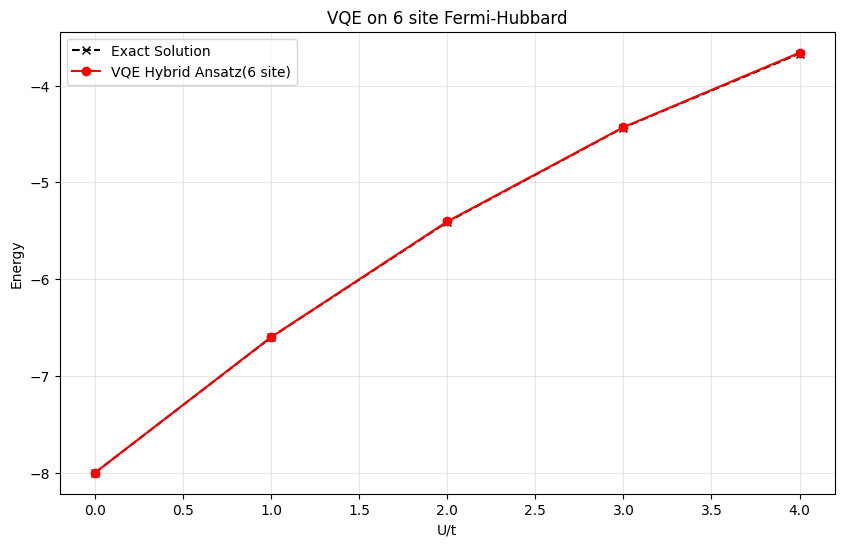


--- Circuit Structure Check ---


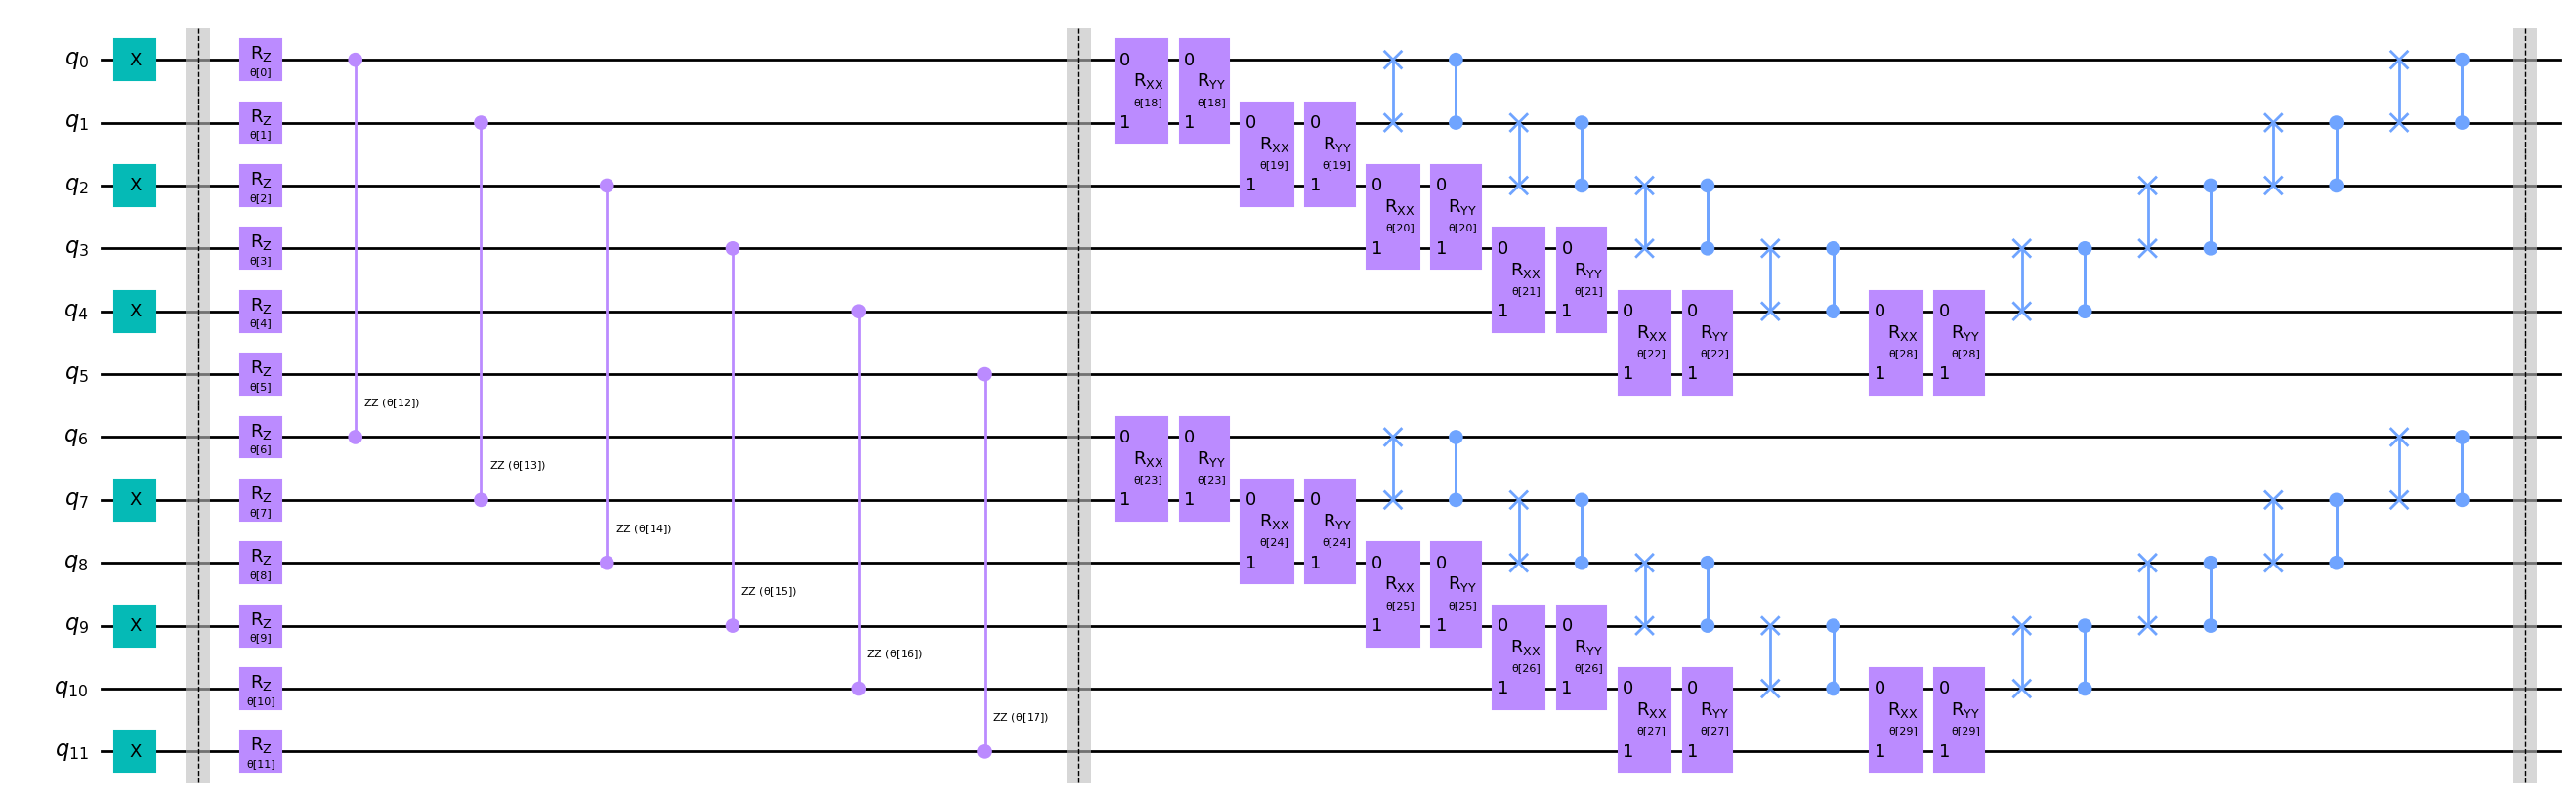

In [6]:
def main():
    t = 1.0
    U_values = [0.0, 1.0, 2.0, 3.0, 4.0]
    reps = 6

    print(f"---  FERMI-HUBBARD 6 site ---")
    print(f"{'U/t':<5} | {'VQE Energy':<12} | {'Exact Energy':<12} | {'Error':<10}")
    print("-" * 50)

    mapper = JordanWignerMapper()
    prev_params = None

    exact_energies = []
    vqe_energies = []

    for U in U_values:
        # 1. Build Operator
        ferm_op = build_fermi_hubbard_hexagon_op(t, U)
        qubit_op = mapper.map(ferm_op)

        # 2. Exact Calculation
        num_terms = {}
        for i in range(12):
            op = f"+_{i} -_{i}"
            num_terms[op] = 1.0
        num_op_ferm = FermionicOp(num_terms, num_spin_orbitals=12)
        num_op_qubit = mapper.map(num_op_ferm)

        def filter_fn(state, eigenvalue, aux_values):
            return np.isclose(aux_values['NumberOp'][0], 6, atol=0.1)

        exact_solver = NumPyMinimumEigensolver(filter_criterion=filter_fn)
        result_exact = exact_solver.compute_minimum_eigenvalue(
            qubit_op,
            aux_operators={'NumberOp': num_op_qubit}
        )
        E_exact = result_exact.eigenvalue.real

        # 3. Run VQE
        ansatz = create_hexagon_ansatz(reps=reps)
        E_vqe, params = run_vqe_simulation(qubit_op, ansatz, init_params=prev_params)
        prev_params = params

        # Lưu kết quả
        exact_energies.append(E_exact)
        vqe_energies.append(E_vqe)

        print(f"{U:<5.1f} | {E_vqe:<12.6f} | {E_exact:<12.6f} | {abs(E_vqe-E_exact):.3e}")

    # --- VẼ ĐỒ THỊ SO SÁNH ---
    plt.figure(figsize=(10, 6))

    # Vẽ Exact
    plt.plot(U_values, exact_energies, 'k--x', label='Exact Solution')
    # Vẽ VQE
    plt.plot(U_values, vqe_energies, 'r-o', label='VQE Hybrid Ansatz(6 site)')
    plt.xlabel('U/t')
    plt.ylabel('Energy')
    plt.title('VQE on 6 site Fermi-Hubbard')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print("\n--- Circuit Structure Check ---")
    sample_qc = create_hexagon_ansatz(reps=1)
    display(sample_qc.draw('mpl', style='clifford', fold=-1))
if __name__ == "__main__":
    main()